## Load data

In [1]:
# read tsv file
import csv
import sys
import ast

# file name: subtask_a_sample.tsv

import pandas as pd

dataDirectory = "./data/"
dataA_train = pd.read_csv(dataDirectory + "subtask_a_train.tsv", sep='\t')
dataA_train['expected_order'] = dataA_train['expected_order'].apply(ast.literal_eval)
dataA_dev = pd.read_csv(dataDirectory + "subtask_a_dev.tsv", sep='\t')
dataA_test = pd.read_csv(dataDirectory +"subtask_a_test.tsv", sep='\t')

dataA = pd.concat([dataA_train,dataA_dev,dataA_test])
# reset index
dataA = dataA.reset_index(drop=True)




In [2]:
def only_train(dataA): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    return pd.concat([dataA[dataA["subset"] == "Sample"],dataA[dataA["subset"]== "Train"]])

In [39]:
tokens = word_tokenize("the pig ear has a white hat and runs fast")
pos_tags = nltk.pos_tag(tokens, tagset='universal')
pos_tags

[('the', 'DET'),
 ('pig', 'NOUN'),
 ('ear', 'NOUN'),
 ('has', 'VERB'),
 ('a', 'DET'),
 ('white', 'ADJ'),
 ('hat', 'NOUN'),
 ('and', 'CONJ'),
 ('runs', 'VERB'),
 ('fast', 'ADV')]

In [3]:
# preprocessing of text of Victoria
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def prepare_text(raw_text):
    
    # Convert text to lowercase and remove punctuation
    normalized_text = raw_text.lower()
    normalized_text = re.sub(r"[^a-zA-Z\s]", "", normalized_text)

    # Tokenize the normalized text
    tokens = word_tokenize(normalized_text)

    # Apply POS tagging and retain only nouns, verbs
    pos_tags = nltk.pos_tag(tokens, tagset='universal')
    pos_tags_to_keep = {"NOUN", "VERB"}
    filtered_tokens = [word for word, pos in pos_tags if pos in pos_tags_to_keep]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in filtered_tokens if word.lower() not in stop_words]

    # Lemmatize the remaining tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    return " ".join(lemmatized_text)


In [4]:
#preprocessed = False
preprocessed = True

if preprocessed == True:
    dataA["sentence"] = dataA["sentence"].apply(prepare_text) 
    dataA["compound"] = dataA["compound"].apply(prepare_text)
 

## BERT model 

### without fine-tuning, classification of idiomatic/literal

Idea: we use a pretrained BERT model to generate embeddings of sentences and of the compound in the context of the sentence.

In [7]:
from transformers import AutoTokenizer

# model is selected from https://huggingface.co/models
checkpoint = 'bert-base-uncased' #"distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer.model_max_length

512

In [8]:
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True)

In [10]:
demonstrate = tokenize(dataA["sentence"][:3].tolist())
for i in range(3):
    print(demonstrate["input_ids"][i])  
    print(demonstrate["attention_mask"][i])
    print(dataA["sentence"][i])
    print()


[101, 2165, 2843, 8999, 21956, 2131, 2214, 3194, 2770, 102, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
took lot elbow grease get old engine running

[101, 5377, 2645, 2851, 2711, 2305, 13547, 2424, 2183, 3637, 3013, 2190, 3178, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
constant battle morning person night owl find going sleep cut best hour

[101, 6534, 2100, 3478, 2797, 3239, 2540, 2751, 2919, 13606, 27983, 102, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
seedy failed private eye heart gold bad hairstyle



"sentence"-column is tokenized and passed to the model.

In [11]:
# tokenize all sentences
dataA_sentence_tokenized = tokenize(dataA["sentence"].tolist())
dataA_compound_tokenized = tokenize(dataA["compound"].tolist())

print(len(dataA_compound_tokenized["input_ids"][0]), len(dataA_sentence_tokenized["input_ids"][0]))
dataA_compound_tokenized["input_ids"][:3]

6 25


[[101, 8999, 21956, 102, 0, 0],
 [101, 2305, 13547, 102, 0, 0],
 [101, 2540, 2751, 102, 0, 0]]

In [12]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint, output_hidden_states=True).to(device)
model = model.eval()


In [13]:
# convert input_ids to tensor
input_ids_sentence = torch.tensor(dataA_sentence_tokenized["input_ids"]).to(device)
attention_mask_sentence = torch.tensor(dataA_sentence_tokenized["attention_mask"]).to(device)

# pass input_ids to model
with torch.no_grad():
    output = model(input_ids_sentence, attention_mask_sentence)



In [14]:
# number of items, number of 
output.last_hidden_state.shape
# number of items, length of input_ids ,number of hidden units

torch.Size([100, 25, 768])

In [15]:
hidden_states_sentence = output.hidden_states

In [16]:
print ("Number of layers:", len(hidden_states_sentence), "  (including initial embeddings)")
layer_i = 0

print ("Number of batches:", len(hidden_states_sentence[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states_sentence[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states_sentence[layer_i][batch_i][token_i]))


Number of layers: 13   (including initial embeddings)
Number of batches: 100
Number of tokens: 25
Number of hidden units: 768


In [17]:
import numpy as np

# different pooling methods for embeddings are computed
# NOTE: padding tokens should be excluded (not done yet)

def get_sentence_embedding(hidden_states,method):
    sentence_embedding = []
    if method == 'meanLast4': # average of all tokens of the last 4 layers
        for i in range(len(hidden_states[0])):
            # token_vecs is mean of last 4 layers
            token_tensor = torch.stack([hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanSecondToLast': # average of second to last layer
        for i in range(len(hidden_states[-2])):
            token_vecs = hidden_states[-2][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanLast': # average of last layer
        for i in range(len(hidden_states[-1])):
            token_vecs = hidden_states[-1][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'lastCLS': # CLS token of last layer
        sentence_embedding = hidden_states[-1][:, 0, :]
    elif method == 'meanFirst': # average of first layer
        for i in range(len(hidden_states[0])):
            token_vecs = hidden_states[0][i]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'firstCLS': # CLS token of first layer
        sentence_embedding = hidden_states[0][:, 0, :]
    return sentence_embedding

In [18]:
# use all methods for getting sentence embeddings and add them to dataA

methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst','firstCLS','lastCLS']

for method in methods:
    X = get_sentence_embedding(hidden_states_sentence,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    # add a new column to dataA 
    dataA['sentence_embedding_'+ method] = X
    



Die Ergebnisse sind erstaunlich gut. Allerdings sind sie auch sehr abhängig von random_state (teste 0,10,13,42)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# mlp
from sklearn.neural_network import MLPClassifier


# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


for method in methods: 
    # get data for training (subset column has value train or sample)
    dataA_train = only_train(dataA)

    X = dataA_train['sentence_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print('=========================================================')
    print(method)
    # logistic regression
#    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#    clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
    clf = SVC(kernel='linear').fit(X_train, y_train)
#    clf = MLPClassifier(random_state=0, max_iter=300).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_pred))

    #classification report
    print(classification_report(y_test, y_pred,zero_division=0))



meanSecondToLast
0.8571428571428571
              precision    recall  f1-score   support

   idiomatic       0.75      1.00      0.86         6
     literal       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14

meanLast4
0.9285714285714286
              precision    recall  f1-score   support

   idiomatic       0.86      1.00      0.92         6
     literal       1.00      0.88      0.93         8

    accuracy                           0.93        14
   macro avg       0.93      0.94      0.93        14
weighted avg       0.94      0.93      0.93        14

meanLast
0.8571428571428571
              precision    recall  f1-score   support

   idiomatic       0.75      1.00      0.86         6
     literal       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88  

In [20]:
# dummy classifier most frequent
from sklearn.dummy import DummyClassifier


# dummy classifier most frequent
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("dummy classifier most frequent")
print(accuracy_score(y_test, y_pred))

#classification report
print(classification_report(y_test, y_pred,zero_division=0))


dummy classifier most frequent
0.42857142857142855
              precision    recall  f1-score   support

   idiomatic       0.43      1.00      0.60         6
     literal       0.00      0.00      0.00         8

    accuracy                           0.43        14
   macro avg       0.21      0.50      0.30        14
weighted avg       0.18      0.43      0.26        14



In [21]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS'],
      dtype='object')

### Compare compound embeddings in sentence and in chatGPT definitions.
#### 1) get contextualized compound embeddings for compounds in sentences

In [22]:
##!pip install inflect


In [23]:
# sometimes the compound occurs in plural form in the sentence

# add a new column to dataA with the plural form of the compound 


from re import *
import inflect

engine = inflect.engine()

dataA["compound_plural"] = [None for i in range(len(dataA))]

for i in range(len(dataA["compound"])):
    dataA["compound_plural"][i] = engine.plural(dataA["compound"][i])

dataA_compound_plural_tokenized = tokenize(dataA["compound_plural"].tolist())

In [24]:
engine = inflect.engine()
t = engine.plural("color in the grass")
tt = engine.plural(t)
t, tt


('colors in the grass', 'colorss in the grass')

In [25]:
dataA["compound_plural"][70:].value_counts

<bound method IndexOpsMixin.value_counts of 70    monkey businesses
71          grass roots
72      marching orders
73           panda cars
74         bread butter
75    chocolate teapots
76             pig ears
77                  men
78          big cheeses
79        eager beavers
80            hair dogs
81            thin ices
82        snake grasses
83         flea markets
84             big fish
85        fancy dresses
86          snail mails
87         heart stones
88        party animals
89            cold feet
90       couch potatoes
91             pea pods
92          sour grapes
93             hot airs
94         green lights
95       watering holes
96       flying saucers
97             act gods
98          field works
99             big wigs
Name: compound_plural, dtype: object>

Sometimes the compound occurs in the sentence only in plural form. So both forms are needed.

In [26]:
tokenizer.tokenize("rotten apples and oranges are in the woodbasket")

['rotten',
 'apples',
 'and',
 'orange',
 '##s',
 'are',
 'in',
 'the',
 'wood',
 '##basket']

In [27]:
# returns the index of the compound in the sentence
def get_idx(compound_tokens, compound_plural_tokens, sentence_tokens):
    # remove 0-tokens from compound_tokens (removes tokens that are due to padding)
    compound_tokens = [i for i in compound_tokens if i != 0]
    # remove [CLS] and [SEP] from compound_tokens
    compound_tokens = compound_tokens[1:-1]
    compound_plural_tokens = [i for i in compound_plural_tokens if i != 0]
    compound_plural_tokens = compound_plural_tokens[1:-1]
    idx = []
    # find the first occurence of the sequence of compound_tokens in sentence_tokens (singular and plural forms)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_tokens)] == compound_tokens:
            for j in range(i, i+ len(compound_tokens)):
                idx.append(j)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_plural_tokens)] == compound_plural_tokens:
            for j in range(i, i+ len(compound_plural_tokens)):
                idx.append(j)
    # remove duplicates from idx
    idx = list(set(idx))
    return idx



In [28]:
#testen
get_idx([99,1,5,100,0,0],[99,1,5,2,100,0,0],[1,5,3,7,4,1,5,2,1,9,0,0,0])

[0, 1, 5, 6, 7]

In [29]:
hidden_states_sentence[-1].shape

torch.Size([100, 25, 768])

In [30]:
# returns the embeddings of the tokens in idxList. 
# The embeddings are combined to a single embedding by different averaging methods
import numpy as np
def get_idxList_embedding(hidden_states,idxLists,method):
    embedding = []
    if method == 'meanLast4':
        for i in range(len(hidden_states[-1])):
            # token_vecs is mean of last 4 layers
            idxList = idxLists[i]
            token_tensor = torch.stack([hidden_states[-1][i][idxList], hidden_states[-2][i][idxList], hidden_states[-3][i][idxList], hidden_states[-4][i][idxList]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanSecondToLast':
        for i in range(len(hidden_states[-2])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-2][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanLast':
        for i in range(len(hidden_states[-1])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-1][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanFirst':
        for i in range(len(hidden_states[0])):
            idxList = idxLists[i]
            token_vecs = hidden_states[0][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    return embedding

In [31]:
# add column to dataA with the indices of the compound in the sentence
dataA["compound_idx"] = [get_idx(dataA_compound_tokenized["input_ids"][i], dataA_compound_plural_tokenized["input_ids"][i], dataA_sentence_tokenized["input_ids"][i]) for i in range(len(dataA))]



In [40]:
# print dataA["sentence"] if compound_idx is empty (ideally there should be no empty compound_idx)
for i in range(len(dataA)):
    if len(dataA["compound_idx"][i]) == 0:
        print(dataA["compound"][i])
        print(dataA["sentence"][i])
        print(i)

white hat
use white ethical search engine optimization technique lead long term success many seo firm use tactic risk harming site
29
pig ear
wrote new partition table made right pig
76


In [41]:

# add column compound_embedding to dataA use method 'meanLast'
compound_methods = ['meanSecondToLast','meanLast4','meanLast','meanFirst']
for method in compound_methods:
    dataA['compound_embedding_'+ method] = get_idxList_embedding(hidden_states_sentence,dataA["compound_idx"],method) 

In [44]:
dataA.iloc[29]

compound                                                                       white hat
subset                                                                             Train
sentence_type                                                                  idiomatic
sentence                               use white ethical search engine optimization t...
expected_order                         [50305046415.png, 39481587509.png, 11696820520...
image1_name                                                              11696820520.png
image1_caption                         The image depicts a light blue baseball cap wi...
image2_name                                                              12124292214.png
image2_caption                         The image depicts a modern multifunction print...
image3_name                                                              13755461305.png
image3_caption                         The image depicts a classic top hat, which is ...
image4_name          

compound_embedding_ enthält die Embedding des Compounds im Sentence

In [208]:

dataA_train = only_train(dataA)


for method in compound_methods:
    X = dataA_train['compound_embedding_'+ method].tolist()
    y = dataA_train["sentence_type"]

    # split in train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    print('=========================================================')
    print(method)
    # logistic regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(accuracy_score(y_test, y_pred))

    #classification report
    print(classification_report(y_test, y_pred,zero_division=0))

meanSecondToLast


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

#### 2) Get contextualized compound embeddings in gpt_sentences and gpt_meaning and gpt_pic embeddings


In [45]:
# read chatGPT data from csv

data_chatGPT_train = pd.read_csv(dataDirectory + "chatGPTNew_train.csv")
data_chatGPT_dev = pd.read_csv(dataDirectory + "chatGPTNew_dev.csv")
data_chatGPT_test = pd.read_csv(dataDirectory + "chatGPTNew_test.csv")
data_chatGPT = pd.concat([data_chatGPT_train,data_chatGPT_dev,data_chatGPT_test])

data_chatGPT = data_chatGPT.reset_index(drop=True)


# rename each column with "gpt_" in front of the column name
data_chatGPT.rename(columns=lambda x: 'gpt_' + x, inplace=True)
data_chatGPT


,gpt_idiomatic_meaning,gpt_literal_meaning,gpt_idiomatic_sentence,gpt_literal_sentence
0,Elbow grease is a metaphor for hard physical e...,Elbow grease is the literal effort of using on...,It took a lot of elbow grease to get the old c...,I used some elbow grease to scrub the stain of...
1,Night owl is a metaphor for a person who tends...,Night owl is a literal term referring to an ow...,"As a night owl, she finds it easier to work on...",The night owl swooped silently through the tre...
2,Heart of gold is a metaphor for someone who is...,Heart of gold is a literal phrase referring to...,"He may seem gruff, but he has a heart of gold ...",The artist crafted a pendant in the shape of a...
3,"Agony aunt is a metaphor for a person, often i...",Agony aunt is a literal term referring to an a...,She decided to write to the magazine's agony a...,My poor agony aunt seemed distressed after hea...
4,Shrinking violet is a metaphor for a shy or in...,Shrinking violet is a literal term for a viole...,"She's a shrinking violet in meetings, preferri...",The shrinking violet in the garden looked deli...
...,...,...,...,...
95,Watering hole is a metaphor for a place where ...,Watering hole is a literal term for a place wh...,The pub has become their regular watering hole...,"The lion approached the watering hole, where o..."
96,Flying saucer is a metaphor for an unidentifie...,Flying saucer is a literal term for a saucer-s...,Many people claimed to have seen a flying sauc...,"The flying saucer hovered above the field, its..."
97,Act of God is a metaphor for an event caused b...,Act of God is a literal term referring to even...,The insurance policy covered damage caused by ...,The town was devastated by an act of God when ...
98,Field work is a metaphor for research or work ...,Field work is a literal term for work done out...,He spent the summer doing field work to study ...,The biologist conducted field work in the rain...


In [46]:
data_chatGPT.columns

Index(['gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence'],
      dtype='object')

In [47]:
data_chatGPT["gpt_idiomatic_meaning"][3]

'Agony aunt is a metaphor for a person, often in a column or publication, who provides advice to people facing personal problems.'

In [48]:
data_chatGPT["compound"] = [None for i in range(len(data_chatGPT))]
for i in range(len(data_chatGPT)):
    data_chatGPT["compound"][i] = data_chatGPT["gpt_idiomatic_meaning"][i].split(" is")[0].strip().lower()

In [124]:
# gpt data needs some cleanup:

# replace ’ with ' in all columns
for column in data_chatGPT.columns:
    data_chatGPT[column] = data_chatGPT[column].str.replace("’","'")



In [125]:
# combine dataA and data_chatGPT
# 
merged_df = pd.merge(dataA, data_chatGPT, on='compound')

In [126]:
merged_df.shape, data_chatGPT.shape, dataA.shape

((100, 31), (100, 5), (100, 27))

In [127]:
dataA = merged_df
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst',
       'gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence'],
      dtype='object')

In [128]:
# Sentence embeddings 

types = ["literal_sentence","idiomatic_sentence","literal_meaning","idiomatic_meaning"]

compound_tokenized = tokenize(dataA["compound"].tolist())
compound_plural_tokenized = tokenize(dataA["compound_plural"].tolist())    

for t in types:
    # tokenize the column
    tokenized = tokenize(dataA["gpt_"+t].tolist())

    # hidden states for gpt_Meaning
    input_ids = torch.tensor(tokenized["input_ids"]).to(device)
    attention_mask = torch.tensor(tokenized["attention_mask"]).to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    hidden_states = output.hidden_states

    # add a columns to data_chatGPT with the embeddings of the gpt_sentence for each method in methods
    for method in methods:
        X = get_sentence_embedding(hidden_states,method)
        X = np.array([x.cpu().numpy() for x in X]).tolist()
        dataA["gpt_"+ t + "_embedding_"+ method] = X
    # add gpt_compound_embeddings

    # identify the indices of the compound in the sentence and use it to get the embeddings of the compound
    dataA["gpt_compound_idx_"+t] = [get_idx(compound_tokenized["input_ids"][i], compound_plural_tokenized["input_ids"][i], tokenized["input_ids"][i]) for i in range(len(dataA))]
    # apply the methods in compound_methods to get the embeddings of the compound
    for method in compound_methods:
        dataA['gpt_compound_embedding_'+ t + "_"+ method] = get_idxList_embedding(hidden_states,dataA["gpt_compound_idx_" + t],method) 


In [129]:
dataA['gpt_compound_embedding_literal_sentence_meanLast'][0]

[1.3850862979888916,
 0.3751792907714844,
 -0.0036504045128822327,
 -0.005035266280174255,
 1.0545681715011597,
 0.3893338143825531,
 -0.5685021281242371,
 0.16046400368213654,
 0.0668158158659935,
 -0.6202495694160461,
 0.527549684047699,
 -0.048127222806215286,
 0.45855432748794556,
 0.5623893737792969,
 -0.7052873373031616,
 0.6542649269104004,
 0.2678602933883667,
 0.29659369587898254,
 0.04114852845668793,
 0.13115344941616058,
 0.596720814704895,
 0.019684240221977234,
 -0.33895641565322876,
 0.4839703440666199,
 0.7045383453369141,
 0.3526879549026489,
 -0.02480529621243477,
 -0.09986043721437454,
 -0.6474232077598572,
 -0.08497404307126999,
 1.1354819536209106,
 -0.011316269636154175,
 0.053069669753313065,
 -0.10691148042678833,
 0.22389322519302368,
 -0.5342385768890381,
 -0.24892759323120117,
 -0.2284896820783615,
 -0.2407369613647461,
 0.14184945821762085,
 -0.5673600435256958,
 -0.1071888655424118,
 -0.07742395251989365,
 0.4590650498867035,
 0.02236570417881012,
 -0.09831

3) ### Use cosine similarity between compound_embedding in sentence and in gpt sentence/meaning to decide idiomatic/literal

In [130]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def compare(emb,emb0,emb1):
    sim0 = cosine_similarity(emb,emb0)
    sim1 = cosine_similarity(emb,emb1)
    if sim0 > sim1:
        return 0
    else:
        return 1

In [131]:
print(dataA.columns)

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst',
       'gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence',
       'gpt_literal_sentence_embedding_meanSecondToLast',
       'gpt_literal_sentence_embedding_meanLast4',
       'gpt_literal_sentence_embedding_meanLast',
       'gpt_literal_sentence_embedding_meanFirst',
       'gpt_liter

In [132]:
for t in ["sentence", "meaning"]:
    m = "meanLast4"

    gpt_compound_embedding_idiomatic = dataA["gpt_compound_embedding_" + "idiomatic_" + t + "_" + m]
    gpt_compound_embedding_literal = dataA["gpt_compound_embedding_" + "literal_" + t + "_" + m]

    preds = []
    for i in range(len(dataA)):
        idx = compare(dataA["compound_embedding_" + m][i],gpt_compound_embedding_literal[i],gpt_compound_embedding_idiomatic[i])
        preds.append(["literal","idiomatic"][idx])

    dataA["pred_compound_sentence_and_compound_" + t] = preds


In [133]:
dataA["pred_compound_sentence_and_compound_sentence"].value_counts(), dataA["pred_compound_sentence_and_compound_meaning"].value_counts()

(idiomatic    59
 literal      41
 Name: pred_compound_sentence_and_compound_sentence, dtype: int64,
 idiomatic    71
 literal      29
 Name: pred_compound_sentence_and_compound_meaning, dtype: int64)

In [134]:
dataA_train = only_train(dataA)

# check accuracy of the predictions: idiomaticity predicted by compound embedding in sentence compared to 
# compound embedding in gpt_sentence 
y = dataA_train["sentence_type"]
y_pred = dataA_train["pred_compound_sentence_and_compound_sentence"]
print("compound sentence")
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred,zero_division=0))

y_pred = dataA_train["pred_compound_sentence_and_compound_meaning"]
print("compound meaning")
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred,zero_division=0))


compound sentence
0.8857142857142857
              precision    recall  f1-score   support

   idiomatic       0.90      0.90      0.90        39
     literal       0.87      0.87      0.87        31

    accuracy                           0.89        70
   macro avg       0.88      0.88      0.88        70
weighted avg       0.89      0.89      0.89        70

compound meaning
0.7428571428571429
              precision    recall  f1-score   support

   idiomatic       0.71      0.92      0.80        39
     literal       0.84      0.52      0.64        31

    accuracy                           0.74        70
   macro avg       0.77      0.72      0.72        70
weighted avg       0.77      0.74      0.73        70



## Cosine similarity between sentences and gpt sentences/meanings

In [135]:
for t in ["sentence", "meaning"]:
    for m in ["lastCLS", "meanLast4"]: 

        gpt_embedding_idiomatic = dataA["gpt_idiomatic_" + t + "_embedding_" + m]
        gpt_embedding_literal = dataA["gpt_literal_" + t + "_embedding_" + m]

        preds = []
        for i in range(len(dataA)):
            idx = compare(dataA["sentence_embedding_" + m][i],gpt_embedding_literal[i],gpt_embedding_idiomatic[i])
            preds.append(["literal","idiomatic"][idx])

        dataA["pred_sentence_and_" + t + "_" + m] = preds


In [136]:
dataA_train = only_train(dataA)

for m in  ["lastCLS", "meanLast4"]:
    # check accuracy of the predictions: idiomaticity predicted by sentence embedding compared to 
    # gpt embedding 
    y = dataA_train["sentence_type"]
    y_pred = dataA_train["pred_sentence_and_sentence_" + m]
    print(m)
    print("sentence")
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred,zero_division=0))
    print("-----------------")

    y_pred = dataA_train["pred_sentence_and_meaning_" + m]
    print("meaning")
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred,zero_division=0))
    print("==========================================")

lastCLS
sentence
0.8285714285714286
              precision    recall  f1-score   support

   idiomatic       0.83      0.87      0.85        39
     literal       0.83      0.77      0.80        31

    accuracy                           0.83        70
   macro avg       0.83      0.82      0.82        70
weighted avg       0.83      0.83      0.83        70

-----------------
meaning
0.6571428571428571
              precision    recall  f1-score   support

   idiomatic       0.64      0.87      0.74        39
     literal       0.71      0.39      0.50        31

    accuracy                           0.66        70
   macro avg       0.67      0.63      0.62        70
weighted avg       0.67      0.66      0.63        70

meanLast4
sentence
0.7571428571428571
              precision    recall  f1-score   support

   idiomatic       0.74      0.87      0.80        39
     literal       0.79      0.61      0.69        31

    accuracy                           0.76        70
   macro 

## Sorting images by cosine similarity of embeddings

In [137]:
# tokenize captions
dataA_image1_caption_tokenized = tokenize(dataA["image1_caption"].tolist())
dataA_image2_caption_tokenized = tokenize(dataA["image2_caption"].tolist())
dataA_image3_caption_tokenized = tokenize(dataA["image3_caption"].tolist())
dataA_image4_caption_tokenized = tokenize(dataA["image4_caption"].tolist())
dataA_image5_caption_tokenized = tokenize(dataA["image5_caption"].tolist())


In [138]:
dataA["image1_caption"][0]

'The image depicts a hand holding a sponge and cleaning a glass cooktop stove. The cooktop is black with three circular burners, and there are some food residue stains on it. The sponge appears to be scrubbing off the stains, indicating that the person is cleaning the cooktop. The background is plain white, focusing attention on the cleaning activity.'

In [139]:
# get embeddings of images
methods = ['meanLast4','lastCLS']

# hidden states for image1_caption
input_ids = torch.tensor(dataA_image1_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image1_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image1 = output.hidden_states

# add a columns to dataA with the embeddings of the image1_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image1,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image1_caption_embedding_'+ method] = X

# hidden states for image2_caption
input_ids = torch.tensor(dataA_image2_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image2_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image2 = output.hidden_states

# add a columns to dataA with the embeddings of the image2_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image2,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image2_caption_embedding_'+ method] = X

# hidden states for image3_caption
input_ids = torch.tensor(dataA_image3_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image3_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image3 = output.hidden_states

# add a columns to dataA with the embeddings of the image3_caption for each method in methods

for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image3,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image3_caption_embedding_'+ method] = X

# hidden states for image4_caption
input_ids = torch.tensor(dataA_image4_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image4_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image4 = output.hidden_states

# add a columns to dataA with the embeddings of the image4_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image4,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image4_caption_embedding_'+ method] = X

# hidden states for image5_caption
input_ids = torch.tensor(dataA_image5_caption_tokenized["input_ids"]).to(device)
attention_mask = torch.tensor(dataA_image5_caption_tokenized["attention_mask"]).to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)

hidden_states_gpt_image5 = output.hidden_states

# add a columns to dataA with the embeddings of the image5_caption for each method in methods
for method in methods:
    X = get_sentence_embedding(hidden_states_gpt_image5,method)
    X = np.array([x.cpu().numpy() for x in X]).tolist()
    dataA['image5_caption_embedding_'+ method] = X
    

KeyboardInterrupt: 

In [51]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst',
       'gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence',
       'gpt_literal_sentence_embedding_meanSecondToLast',
       'gpt_literal_sentence_embedding_meanLast4',
       'gpt_literal_sentence_embedding_meanLast',
       'gpt_literal_sentence_embedding_meanFirst',
       'gpt_liter

In [52]:
pred_rankings = []
for i in range(len(dataA)):
    # compare cosine similarity of each picture_caption_embedding_meanLast4 and compound_embedding_meanLast4
    compound_embedding = dataA['compound_embedding_meanLast4'][i]
    image1_caption_embedding = dataA['image1_caption_embedding_meanLast4'][i]
    image2_caption_embedding = dataA['image2_caption_embedding_meanLast4'][i]
    image3_caption_embedding = dataA['image3_caption_embedding_meanLast4'][i]
    image4_caption_embedding = dataA['image4_caption_embedding_meanLast4'][i]
    image5_caption_embedding = dataA['image5_caption_embedding_meanLast4'][i]
    similarity1 = cosine_similarity(compound_embedding,image1_caption_embedding)
    similarity2 = cosine_similarity(compound_embedding,image2_caption_embedding)
    similarity3 = cosine_similarity(compound_embedding,image3_caption_embedding)
    similarity4 = cosine_similarity(compound_embedding,image4_caption_embedding)
    similarity5 = cosine_similarity(compound_embedding,image5_caption_embedding)
    # sort the similarities
    similarities = [similarity1,similarity2,similarity3,similarity4,similarity5]
    # sort and give indices
    idx = np.argsort(similarities)
    # reverse the indices
    idx = idx[::-1]
    pred_rankings.append(idx)
dataA['pred_rankings'] = pred_rankings



In [53]:
similarities, idx

([0.518004593754709,
  0.5185237546639729,
  0.46498319599465376,
  0.47907611653834337,
  0.4953950573338801],
 array([1, 0, 4, 3, 2], dtype=int64))

In [54]:
dataA["pred_rankings"][0]

array([1, 3, 0, 2, 4], dtype=int64)

In [57]:
# functions to display images

from PIL import Image
from IPython.display import display


fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

# Open the image file
def display_image(compound, fn):
    img = Image.open(fileDirectory + "\\" + compound + "\\" + fn)
    new_size = (150, 150)  # Width, Height
    img_resized = img.resize(new_size)  
    # Display the image
    display(img_resized)

# returns list of image names sorted from image1 to image5
def get_image_names(n,mydata):
    names = []
    for i in [1,2,3,4,5]:
         names.append(mydata['image' + str(i) + '_name'][n])
    return names


In [59]:
# print information of 1 item:

def print_item(n, mydata):
    # print  'sentence_type', 'sentence'
    compound = mydata['compound'][n]
    print(compound)
    print(mydata['sentence_type'][n])
    print(mydata['sentence'][n])
    print('---------------------------------------------------------------------')


    # for image_names in 'expected_order' print image_captions
    names  =  get_image_names(n,mydata)
    expected_order = mydata['expected_order'][n]

    for image_name in expected_order:
        display_image(compound, image_name)
        # get index of image_name in names
        index = names.index(image_name) + 1
        print(mydata['image'+str(index)+'_caption'][n])
    

In [ ]:
for i in range(len(dataA)):
    idxs = dataA['pred_rankings'][i]
    picture_names = get_image_names(i,dataA)
    # sort picture_names according to idxs
    picture_names = [picture_names[i] for i in idxs]
    dataA["pred_rankings"][i] = picture_names    


In [61]:
get_image_names(69,dataA)

['21271058237.png',
 '37795851361.png',
 '48528496115.png',
 '57390097066.png',
 '95410072019.png']

In [62]:
dataA["pred_rankings"][69], dataA["expected_order"][69]

(['37795851361.png',
  '57390097066.png',
  '95410072019.png',
  '48528496115.png',
  '21271058237.png'],
 ['37795851361.png',
  '57390097066.png',
  '21271058237.png',
  '95410072019.png',
  '48528496115.png'])

In [63]:
dataA['expected_order'][0],dataA['pred_rankings'][0]

(['35234427395.png',
  '53378381715.png',
  '39938261459.png',
  '74852536462.png',
  '54879908369.png'],
 ['39938261459.png',
  '54879908369.png',
  '35234427395.png',
  '53378381715.png',
  '74852536462.png'])

In [64]:
def top1accuracy(pred_rankings,expected_order):
    correct = 0
    for i in range(len(pred_rankings)):
        if pred_rankings[i][0] == expected_order[i][0]:
            correct += 1
    return correct/len(pred_rankings)

from scipy.stats import spearmanr

def spearman_correlation(pred_rankings,expected_order):
    corr = []
    for i in range(len(pred_rankings)):
        corr.append(spearmanr(pred_rankings[i],expected_order[i]).correlation)
    return np.mean(corr)


In [65]:
dataA_train = only_train(dataA)
print("compare image captions with sentence")
print("top1 accuracy")
print(top1accuracy(dataA_train['pred_rankings'],dataA_train['expected_order']))

print("spearman rank correlation")
print(spearman_correlation(dataA_train['pred_rankings'],dataA_train['expected_order']))



compare image captions with sentence
top1 accuracy
0.21428571428571427
spearman rank correlation
0.03999999999999999


## use gpt sentence/meaning (compound) embeddings to classify image captions 

Ziel: sortiere die 5 Bilder wie folgt
1: literal, 2: ähnlich wie literal, 3: ähnlich wie idiomatic, 4: idiomatic, 5: unrelated 

In [66]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst',
       'gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence',
       'gpt_literal_sentence_embedding_meanSecondToLast',
       'gpt_literal_sentence_embedding_meanLast4',
       'gpt_literal_sentence_embedding_meanLast',
       'gpt_literal_sentence_embedding_meanFirst',
       'gpt_liter

In [67]:
sim_to_literal = []
sim_to_idiomatic = []
m = "meanLast4"

n = 40

#emb_lit = dataA["gpt_compound_embedding_literal_meaning_" +m][n]
#emb_id = dataA["gpt_compound_embedding_idiomatic_meaning_" +m][n]


emb_lit = dataA["gpt_literal_sentence_embedding_" +m][n]
emb_id = dataA["gpt_idiomatic_sentence_embedding_" +m][n]


#emb_lit = dataA["gpt_literal_meaning_embedding_" +m][n]
#emb_id = dataA["gpt_idiomatic_meaning_embedding_" +m][n]

for i in [1,2,3,4,5]:
    emb_image = dataA["image" + str(i) + "_caption_embedding_" + m][n]
    sim_to_literal.append(cosine_similarity(emb_lit,emb_image))
    sim_to_idiomatic.append(cosine_similarity(emb_id,emb_image))

idx_lit = np.argsort(sim_to_literal )
idx_id = np.argsort(sim_to_idiomatic )
# reverse the indices
idx_lit = idx_lit[::-1].tolist()
idx_id = idx_id[::-1].tolist()


name_list = get_image_names(n,dataA)

name_list_lit = [name_list[j] for j in idx_lit]
name_list_id = [name_list[j] for j in idx_id]



spring chicken
literal
Spring chicken is a literal term for a chicken born in the spring season.


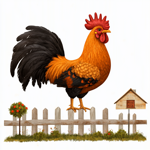

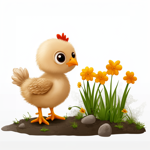

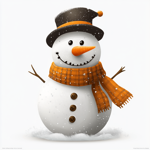

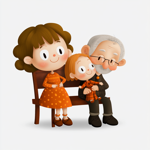

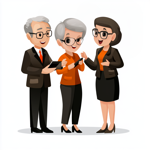

idiomatic
Spring chicken is a metaphor for someone who is young or youthful.


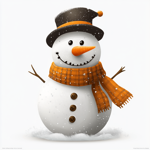

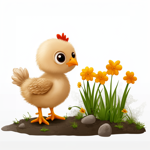

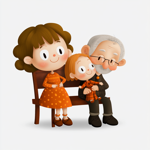

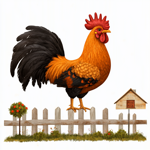

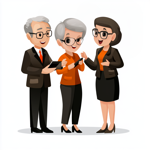

In [68]:
fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask A Train\\train'

compound = dataA["compound"][n]
print(compound)
print("literal")
print(dataA["gpt_literal_meaning"][n])
for fn in name_list_lit:
    display_image(compound,fn)

print("idiomatic")
print(dataA["gpt_idiomatic_meaning"][n])
for fn in name_list_id:
    display_image(compound,fn)



In [69]:
dataA["expected_order"]

0     [35234427395.png, 53378381715.png, 39938261459...
1     [61697797701.png, 93189810779.png, 89375227504...
2     [86137977215.png, 78062290185.png, 54240592941...
3     [83600499282.png, 57658144685.png, 02512838127...
4     [77861539717.png, 68016869942.png, 11844321898...
                            ...                        
95                                                  NaN
96                                                  NaN
97                                                  NaN
98                                                  NaN
99                                                  NaN
Name: expected_order, Length: 100, dtype: object

In [70]:
# compare all pictures to each other and get 2 pairs of most similar ones.

#m="meanLast4"
m= "lastCLS"
n= 45

dataA["pairs"] = [None for p in range(len(dataA))]

for n in range(len(dataA)):
    sim = np.zeros((5,5))

    for i in range(5):
        emb_image_i = dataA["image" + str(i+1) + "_caption_embedding_" + m][n]
        for j in range(i+1,5):
            emb_image_j = dataA["image" + str(j+1) + "_caption_embedding_" + m][n]
            sim[i,j] = cosine_similarity(emb_image_i,emb_image_j)
        
       
    name_list = get_image_names(n,dataA)
    compound = dataA["compound"][n]
    
    u,v = np.unravel_index(np.argmax(sim),sim.shape) # indices of pair with highest similarity 
    simN = np.delete(sim,[u,v],0)
    simN = np.delete(simN,[u,v],1)
    max = np.max(simN)
    b = np.where(sim == max)
    u1 = b[0][0] # u1,v1 indices of pair with second highest similarity 
    v1 = b[1][0]

    unrel = list(set([0,1,2,3,4])-set([u,v,u1,v1]))[0]
    dataA["pairs"][n] = [[(v+1,u+1),(v1+1,u1+1),unrel+1],[(name_list[v],name_list[u]),(name_list[v1],name_list[u1]),name_list[unrel]]]


     


In [71]:
dataA["pairs"][0][0]

[(3, 1), (5, 4), 2]

In [72]:
dataA["literal_image"] = [None for p in range(len(dataA))]
dataA["idiomatic_image"] = [None for p in range(len(dataA))]
dataA["unrelated_image"] = [None for p in range(len(dataA))]

m = "meanLast4"
for n in range(len(dataA)):
    [(u1,v1),(u2,v2),un] = dataA["pairs"][n][0]
    # compare to gpt_sentence_embedding
    comp_lit = dataA["gpt_literal_meaning_embedding_" + m][n]
    comp_id = dataA["gpt_idiomatic_meaning_embedding_" + m][n]
    lit_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_lit)
    lit_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_lit)
    id_sim11 = cosine_similarity(dataA["image"+str(u1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim12 = cosine_similarity(dataA["image"+str(v1)+"_caption_embedding_"+ m][n], comp_id)
    id_sim21 = cosine_similarity(dataA["image"+str(u2)+"_caption_embedding_"+ m][n], comp_id)
    id_sim22 = cosine_similarity(dataA["image"+str(v2)+"_caption_embedding_"+ m][n], comp_id)
    if np.max([lit_sim11,  lit_sim12]) > np.max([lit_sim21 , lit_sim22]):
        if lit_sim11 > lit_sim12:
            dataA["literal_image"][n] = (u1,v1)
        else:
            dataA["literal_image"][n] = (v1,u1)
        if id_sim21 > id_sim22:
            dataA["idiomatic_image"][n] = (u2,v2)
        else: 
            dataA["idiomatic_image"][n] = (v2,u2)
    else:
        if lit_sim21 > lit_sim22:
            dataA["literal_image"][n] = (u2,v2)
        else:
            dataA["literal_image"][n] = (v2,u2)
        if id_sim11 > id_sim12:
            dataA["idiomatic_image"][n] = (u1,v1)
        else:
            dataA["idiomatic_image"][n] = (v1,u1)
    dataA["unrelated_image"][n] = un  


            
    
    
    
     
                                 
                               

In [73]:
dataA["pred_rankings_combined"] = [0 for p in range(len(dataA))]

for n in range(len(dataA)):
    if dataA["pred_sentence_and_sentence_meanLast4"][n] == "literal":
        pred_idx = [dataA["literal_image"][n][0],
                    dataA["literal_image"][n][1],
                    dataA["idiomatic_image"][n][1],
                    dataA["idiomatic_image"][n][0],
                    dataA["unrelated_image"][n]]
    else:
        pred_idx = [dataA["idiomatic_image"][n][0],
                    dataA["idiomatic_image"][n][1],
                    dataA["literal_image"][n][1],
                    dataA["literal_image"][n][0],
                    dataA["unrelated_image"][n]]
    names = get_image_names(n,dataA)
    preds = [names[i-1] for i in pred_idx]
    dataA["pred_rankings_combined"][n] = preds
    




C:\Users\Wiebke Petersen\AppData\Local\Temp\ipykernel_10196\4259230374.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataA["pred_rankings_combined"][n] = preds


In [74]:
dataA["pred_rankings_combined"]

0     [54879908369.png, 74852536462.png, 35234427395...
1     [00982495584.png, 61697797701.png, 93189810779...
2     [78062290185.png, 86137977215.png, 92088849364...
3     [57658144685.png, 02512838127.png, 83600499282...
4     [77861539717.png, 68016869942.png, 11844321898...
                            ...                        
95    [75931438067.png, 10734342674.png, 88336355173...
96    [27939388808.png, 92467678238.png, 28810159615...
97    [73444821016.png, 81503831939.png, 96149522237...
98    [73818470572.png, 39911572381.png, 38700355591...
99    [66170384579.png, 66003146576.png, 94265143928...
Name: pred_rankings_combined, Length: 100, dtype: object

In [75]:
dataA_train = only_train(dataA)

print("combined approach idiomaticity + image caption analysis")
print("top1 accuracy")
print(top1accuracy(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))

print("spearman rank correlation")
print(spearman_correlation(dataA_train['pred_rankings_combined'],dataA_train['expected_order']))


combined approach idiomaticity + image caption analysis
top1 accuracy
0.3142857142857143
spearman rank correlation
0.10285714285714284


In [76]:



def find_permutation(L1, L2):
    oneline = []
    for n in L1:
        # Look for n in L2.
        # Sage's one-line permutation format expects indices to start at 1, not 0,
        # so add 1 to all indices here.
        j = L2.index(n) + 1
        # If we've already found this instance, look in the rest of the list for another one.
        while j in oneline:
            j += L2[j:].index(n) + 1
        oneline.append(j)
    return oneline



In [77]:
dataA_train = only_train(dataA)

lit_acc = 0
id_acc = 0
un_acc = 0
for n in range(len(dataA_train)):
    [lit,id,un] = dataA_train["pairs"][n][0]
    order = dataA_train["expected_order"][n]
    names = get_image_names(n,dataA_train)
    order = find_permutation(names,order)
#    print(order)
    if order[4] == un:
        un_acc = un_acc + 1
    if dataA_train["sentence_type"][n] == "literal":
        order = [(order[0],order[1]),(order[3],order[2]),order[4]]
    else:
        order = [(order[3],order[2]),(order[1],order[0]),order[4]]
    lit_acc = lit_acc + 1 - len(list(set(lit)-set(order[0])))/2 
    id_acc = id_acc + 1 - len(list(set(id)-set(order[1])))/2 
print("accuracy on unrelated: ", un_acc/len(dataA_train))
print("accuracy on literal: ", lit_acc/len(dataA_train))
print("accuracy on idiomatic: ", id_acc/len(dataA_train))




accuracy on unrelated:  0.24285714285714285
accuracy on literal:  0.38571428571428573
accuracy on idiomatic:  0.4


In [78]:
#save dataA pickle
import pickle
dataA.to_pickle("dataA.pkl")


In [79]:
# read in pickle file dataA.pkl

dataA = pd.read_pickle('dataA.pkl')

In [50]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'sentence_embedding_meanSecondToLast',
       'sentence_embedding_meanLast4', 'sentence_embedding_meanLast',
       'sentence_embedding_meanFirst', 'sentence_embedding_firstCLS',
       'sentence_embedding_lastCLS', 'compound_plural', 'compound_idx',
       'compound_embedding_meanSecondToLast', 'compound_embedding_meanLast4',
       'compound_embedding_meanLast', 'compound_embedding_meanFirst'],
      dtype='object')

Mehr in Funktionen packen. 
Bei Captions nur 2 Sätze betrachten.
Weg über idiomatic/literal und dann erst Bilder auswählen. 

## chatgpt image descriptions

In [ ]:
data_gpt_image = pd.read_csv(dataDirectory  + "gpt_image_descriptions_all.csv", sep=',')
# gpt data needs some cleanup:
# replace ’ with ' in all columns
for column in data_gpt_image.columns:
    data_gpt_image[column] = data_gpt_image[column].str.replace("’","'")



merged_df = pd.merge(dataA, data_gpt_image, on='compound')
dataA = merged_df 


In [ ]:
# Sentence embeddings 

types = ["literal_image","idiomatic_image"]


for t in types:
    # tokenize the column
    tokenized = tokenize(dataA["gpt_" + t].tolist())

    # hidden states for gpt_Meaning
    input_ids = torch.tensor(tokenized["input_ids"]).to(device)
    attention_mask = torch.tensor(tokenized["attention_mask"]).to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    hidden_states = output.hidden_states

    # add a columns to data_chatGPT with the embeddings of the gpt_sentence for each method in methods
    for method in methods:
        X = get_sentence_embedding(hidden_states,method)
        X = np.array([x.cpu().numpy() for x in X]).tolist()
        dataA["gpt_"+ t + "_embedding_"+ method] = X
    # add gpt_compound_embeddings



In [88]:
dataA.columns

Index(['compound', 'subset', 'sentence_type', 'sentence', 'expected_order',
       'image1_name', 'image1_caption', 'image2_name', 'image2_caption',
       'image3_name', 'image3_caption', 'image4_name', 'image4_caption',
       'image5_name', 'image5_caption', 'gpt_idiomatic_image',
       'gpt_literal_image', 'gpt_literal_image_embedding_meanLast4',
       'gpt_literal_image_embedding_lastCLS',
       'gpt_idiomatic_image_embedding_meanLast4',
       'gpt_idiomatic_image_embedding_lastCLS'],
      dtype='object')

## Zweistufig: (a) +/- idiomatic, (b) compare picture captions